# Import Packages

In [ ]:
try:
  import tension
except ImportError:
  !git clone https://github.com/zhenruiliao/tension.git tension
  !pip install -e tension
  print('Stopping RUNTIME! Please run again.')
  import os
  os.kill(os.getpid(), 9)

In [ ]:
from tension.base import FORCEModel
from tension.models import NoFeedbackESN, FullFORCEModel
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Define Sum of Sinusoid Target

From https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0191527

In [ ]:
def fullforce_oscillation_test(dt, showplots=0):
    dt_per_s = round(1/dt)
    
    # From the paper, and the online demo:
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.zeros((2*dt_per_s+1,1))
    omega = np.linspace(2*np.pi, 6*np.pi, 1*dt_per_s+1)
    targ = np.zeros((2*dt_per_s+1,1))
    targ[0:(1*dt_per_s+1),0] = np.sin(t[0:(1*dt_per_s+1),0]*omega)
    targ[1*dt_per_s:(2*dt_per_s+1)] = -np.flipud(targ[0:(1*dt_per_s+1)])
    
    # A simpler example: just a sine wave
    '''
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.ones((2*dt_per_s+1,1)) * 4 *np.pi
    targ = np.sin(t*omega)
    '''
    
    # A slightly harder example: sum of sine waves
    
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.ones((2*dt_per_s+1,1)) * 4 *np.pi
    targ = np.sin(t*2*omega) * np.sin(t*omega/4)
    
    
    inp = np.zeros(targ.shape)
    inp[0:round(0.05*dt_per_s),0] = np.ones((round(0.05*dt_per_s)))
    hints = np.zeros(targ.shape)

    if showplots == 1:
        plt.figure()
        plt.plot(targ)
        plt.plot(hints)
        plt.plot(inp)
        plt.legend(['Target','Hints','Input'])
    
    return inp, targ, hints

# Create input and target

(801, 2) (801, 1)


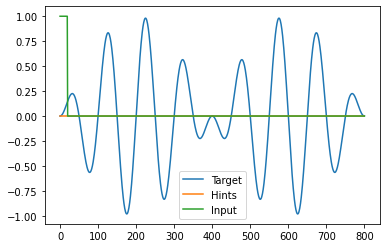

In [ ]:
dt = 0.0025
tau = 10*dt
inputs, target, hints = fullforce_oscillation_test(dt=dt,showplots=1)

inputs_with_hint = np.concatenate([inputs, hints], axis=1).astype(np.float32)
target = target.astype(np.float32)
hd = hints.shape[-1]
print(inputs_with_hint.shape, target.shape)

# Define training parameters

In [ ]:
n_epoch = 5 # number of epochs to train
m = 1 # output dimension
n = 750 # number of recurrent neurons

# Training an echo state network without feedback using FORCE

**Note:** This will take approximately 5 minutes on Colab GPU

In [ ]:
%%time 
tf.random.set_seed(123)

no_fb_esn_layer = NoFeedbackESN(dtdivtau=dt/tau,
                                units=n,
                                output_size=m,
                                activation='tanh',
                                seed=123)
force_model = FORCEModel(force_layer=no_fb_esn_layer)
force_model.compile(metrics=["mae"])
history = force_model.fit(x=inputs_with_hint,
                          y=target,
                          epochs=n_epoch)
predictions_force = force_model.predict(inputs_with_hint)

Epoch 1/5
801/801 [==============================] - 65s 76ms/step - mae: 0.0117
Epoch 2/5
801/801 [==============================] - 60s 75ms/step - mae: 0.0083
Epoch 3/5
801/801 [==============================] - 61s 76ms/step - mae: 0.0096
Epoch 4/5
801/801 [==============================] - 61s 76ms/step - mae: 0.0082
Epoch 5/5
801/801 [==============================] - 61s 76ms/step - mae: 0.0048
CPU times: user 5min 2s, sys: 5.41 s, total: 5min 7s
Wall time: 5min 28s


# Training an echo state network without feedback using full-FORCE

In [ ]:
%%time 
tf.random.set_seed(123)

no_fb_esn_layer = NoFeedbackESN(dtdivtau=dt/tau,
                                units=n,
                                output_size=m,
                                activation='tanh',
                                seed=123)
ffmodel = FullFORCEModel(force_layer=no_fb_esn_layer,
                         hint_dim=hd,
                         target_output_kernel_trainable=False)
ffmodel.compile(metrics=["mae"])
history = ffmodel.fit(x=inputs_with_hint,
                      y=target,
                      epochs=n_epoch)
predictions_ff = ffmodel.predict(inputs)

Epoch 1/5
801/801 [==============================] - 3s 2ms/step - mae: 0.0142
Epoch 2/5
801/801 [==============================] - 2s 2ms/step - mae: 0.0102
Epoch 3/5
801/801 [==============================] - 2s 2ms/step - mae: 0.0099
Epoch 4/5
801/801 [==============================] - 2s 2ms/step - mae: 0.0077
Epoch 5/5
801/801 [==============================] - 2s 2ms/step - mae: 0.0050
CPU times: user 13 s, sys: 964 ms, total: 14 s
Wall time: 12.5 s


# Plotting targets and predictions

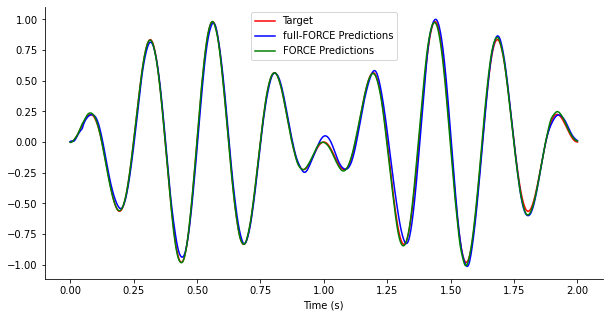

In [ ]:
x = np.arange(0, inputs.shape[0]) * dt

fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10,5))
ax1.plot(x, target, color='r', label='Target', linewidth=1.5)
ax1.plot(x, predictions_ff, color='b', label='full-FORCE Predictions', linewidth=1.5)
ax1.plot(x, predictions_force, color='g', label='FORCE Predictions', linewidth=1.5)

ax1.set_xlabel('Time (s)')
ax1.legend()
sns.despine(ax=ax1)